<img src="QuSCo_Logo_CMYK.jpg" alt="Here should be the qusco logo!" width="500">

---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from qutip.control import *
from qutip.control.grape import _overlap, cy_grape_unitary
from qutip.ui.progressbar import TextProgressBar

# Exercise 1 - Optimising a single-qubit rotation using GRAPE
$\newcommand{op}[1]{\hat{#1}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}$

First, we define the time grid of the
dynamics. As an example, we define the
initial state to be at time $t=0$ and
consider a total propagation time of
$T=2\pi$. The entire time grid is divided into
$n_{t}=100$ equidistant time steps.

In [2]:
T = 2*np.pi
times = np.linspace(0, T, 100)

Next, we define the optimisation goal, which will be a single qubit rotation around the Bloch angles $\theta$ and $\phi$.

In [3]:
theta = 1*np.pi
phi = 0*np.pi
U = rz(phi) * rx(theta); U

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.+0.j 0.-1.j]
 [0.-1.j 0.+0.j]]

The Hamiltonian
$\op{H}_{0} = - \omega \op{\sigma}_{z}$
represents a
simple qubit with energy
level splitting $\omega$ in the basis
$\{\ket{0},\ket{1}\}$. The control
field
$u(t)$ is assumed to couple via
the
Hamiltonian $\op{H}_{1}(t) =
u(t) \op{\sigma}_{x}$ to the qubit,
i.e., the control
field effectively
drives
transitions between both qubit
states.

In [4]:
omega = 1
H0 = -0.5 * omega * sigmaz()
H_ops = [sigmax()]
H_labels = [r'$u_{x}$']

# Set the guess pulse

Now we define and plot a random guess pulse with amplitude $0.25$ and smooth it out afterwards.

In [5]:
u0 = np.array([np.random.rand(len(times)) * 0.25 for _ in range(len(H_ops))]) #Generate random guess

u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))] #Smooth out the random guess?

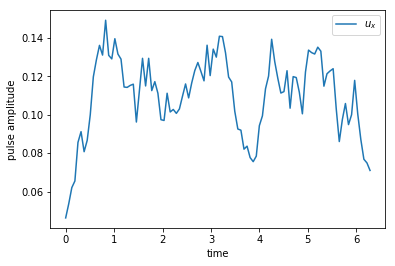

In [6]:
def plot_pulse(pulse, labels, tlist):
    fig, ax = plt.subplots()
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    for i in range(0,shape(pulse)[0]):
        ax.plot(tlist, pulse[i],label=labels[i])
    ax.legend()
    plt.show(fig)
    
plot_pulse(u0, H_labels, times)

Now we propagate the guess pulse using `mesolve` and plot the results on the Bloch sphere.

/home/sabrina/anaconda3/envs/qucontrolenv/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/sabrina/qusco_school_2019/notebooks/rhs29460.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


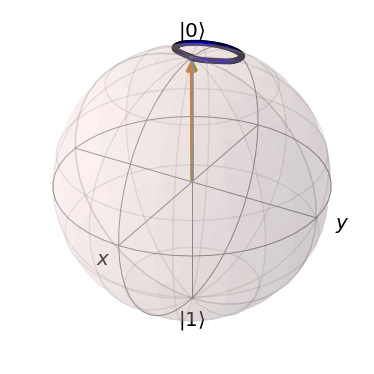

In [7]:
def plot_bloch(ham, tlist):
    psi0 = basis(2, 0) #Initial state
    c_ops = [] #collapse operators
    e_ops = [] #expectation values
    
    #Propagate
    me_result = mesolve(ham, psi0, tlist, c_ops, e_ops)
    
    #Set the operators to calculate the expectation values
    e_ops = [sigmax(), sigmay(), sigmaz()]
    
    b = Bloch() #Generate Bloch sphere
    b.add_points(expect(e_ops,me_result.states)) #Add trajectory
    b.add_states(psi0) #Add initial state vector
    b.add_states(me_result.states[-1]) #Add target state vector
    b.render()
    
#Write the total Hamiltonian in the desired format
H_t = [H0]
for i in range(0,len(H_ops)):
    H_t.append([H_ops[i], u0[i]])

plot_bloch(H_t, times)

# GRAPE optimisation

In [8]:
R = 100 #Number of iterations
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2*np.pi/T, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time:   5.53s. Est. time left: 00:00:00:49
20.0%. Run time:   9.86s. Est. time left: 00:00:00:39
30.0%. Run time:  14.15s. Est. time left: 00:00:00:33
40.0%. Run time:  18.74s. Est. time left: 00:00:00:28
50.0%. Run time:  23.99s. Est. time left: 00:00:00:23
60.0%. Run time:  29.02s. Est. time left: 00:00:00:19
70.0%. Run time:  33.18s. Est. time left: 00:00:00:14
80.0%. Run time:  37.32s. Est. time left: 00:00:00:09
90.0%. Run time:  41.44s. Est. time left: 00:00:00:04
Total run time:  46.35s


In [9]:
# unitary from grape pulse
result.U_f

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 1.61304244e-09+5.22435689e-10j  4.59538407e-08-1.00000000e+00j]
 [-4.59538403e-08-1.00000000e+00j  1.61304183e-09-5.22436029e-10j]]

In [10]:
# Fidelity
print(abs(_overlap(U, result.U_f))**2*100,'%')

99.99999999999983 %


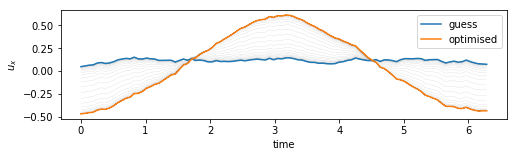

In [11]:
def plot_optimal_pulse(pulse, labels, tlist):    
    R, J, M = pulse.shape
    fig, axes = plt.subplots(J, 1, figsize=(8, 2 * J), squeeze=False)
    
    for j in range(J):
        ax = axes[j, 0]
        ax.set_xlabel('time')
        ax.set_ylabel(labels[j])
        for i in range(1,shape(pulse)[0]-1):
            ax.plot(tlist, pulse[i,j,:],color='gray',linewidth=0.1)
        ax.plot(tlist, pulse[0,j,:],label='guess')
        ax.plot(tlist, pulse[-1,j,:],label='optimised')
        ax.legend()
    plt.show(fig)
    
plot_optimal_pulse(result.u, H_labels, times)

/home/sabrina/anaconda3/envs/qucontrolenv/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/sabrina/qusco_school_2019/notebooks/rhs29461.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


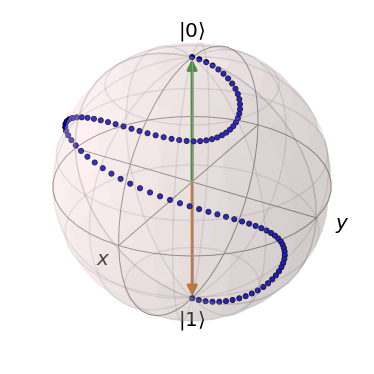

In [12]:
plot_bloch(result.H_t, times)

# Tasks
1a) Implement a two-qubit gate, for instance  a CNOT gate
\begin{equation*}
\hat{U} =  \begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}
\end{equation*}
There are several options to choose the controls.

Keep in mind that the visualisation on the single qubit Bloch sphere is no longer possible. It might be helpful to check other possibilities to visualise quantum states and processes: http://qutip.org/docs/3.1.0/guide/guide-visualization.html